In [27]:
#######################################################################
#####                                                             #####
#####     SPARSE IDENTIFICATION OF NONLINEAR DYNAMICS (SINDy)     #####
#####     Application to the Lotka-Volterra system                #####
#####                                                             #####
#######################################################################

"""

This small example illustrates the identification of a nonlinear
dynamical system using the data-driven approach SINDy with constraints
by Loiseau & Brunton (submitted to JFM Rapids).

Note: The sklearn python package is required for this example.
----

Contact: loiseau@mech.kth.se

"""


#--> Import standard python libraries
from math import *
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#--> Import some features of scipy to simulate the systems
#    or for matrix manipulation.
from scipy.integrate import odeint
from scipy.linalg import block_diag

#--> Import the PolynomialFeatures function from the sklearn
#    package to easily create the library of candidate functions
#    that will be used in the sparse regression problem.
from sklearn.preprocessing import PolynomialFeatures

#--> Import the sparse identification python package containing
#    the class to create sindy estimators.
import sparse_identification as sp
from sparse_identification.utils import derivative as spder
from sparse_identification.solvers import hard_threshold_lstsq_solve
from sparse_identification.utils import derivative

#--> Defines various functions used in this script.

def Lotka_Volterra(x0, r, a, time):
    def dynamical_system(y,t):
        dy = np.zeros_like(y)
        for i in range(4):
            dy[i] = r[i]*y[i]*(1-a[i][0]*y[0]-a[i][1]*y[1]-a[i][2]*y[2]-a[i][3]*y[3])
        return dy

    x = odeint(dynamical_system,x0,time,mxstep=0)
    dt = time[1]-time[0]
    xdot = spder(x,dt)

    return x, xdot

def constraints(library):

    """

    This function illustrates how to impose some
    user-defined constraints for the sparse identification.

    Input
    -----

    library : library object used for the sparse identification.

    Outputs
    -------

    C : two-dimensional numpy array.
        Constraints to be imposed on the regression coefficients.

    d : one-dimensional numpy array.
        Value of the constraints.

    """

    #--> Recover the number of input and output features of the library.
    m = library.n_input_features_
    n = library.n_output_features_

    #--> Initialise the user-defined constraints matrix and vector.
    #    In this example, two different constraints are imposed.
    C = np.zeros((2, m*n))
    d = np.zeros((2,1))

    #--> Definition of the first constraint:
    #    In the x-equation, one imposes that xi[2] = -xi[1]
    #    Note: xi[0] corresponds to the bias, xi[1] to the coefficient
    #    for x(t) and xi[2] to the one for y(t).
    C[0, 1] = 1
    C[0, 2] = 1

    #--> Definition of the second constraint:
    #    In the y-equation, one imposes that xi[1] = 28
    #    Note: the n+ is because the coefficient xi[1] for
    #    the y-equation is the n+1th entry of the regression
    #    coefficients vector.
    C[1, n+1] = 1
    d[1] = 28

    return C, d

def Identified_Model(y, t, library, estimator) :

    '''
    Simulates the model from Sparse identification.

    Inputs
    ------

    library: library object used in the sparse identification
             (e.g. poly_lib = PolynomialFeatures(degree=3) )

    estimator: estimator object obtained from the sparse identification

    Output
    ------

    dy : numpy array object containing the derivatives evaluated using the
         model identified from sparse regression.

    '''

    dy = np.zeros_like(y)

    lib = library.fit_transform(y.reshape(1,-1))
    Theta = block_diag(lib, lib, lib, lib)
    dy = Theta.dot(estimator.coef_)

    return dy

def perturb_parameters(p, mean=0, stdev=0):
    return p + np.random.normal(mean, stdev, size=p.shape)

In [28]:
true_r = np.array([1, 0.72, 1.53, 1.27])
true_a = np.array([[1, 1.09, 1.52, 0], 
                  [0, 1, 0.44, 1.36], 
                  [2.33, 0, 1, 0.47], 
                  [1.21, 0.51, 0.35, 1]])

In [38]:
def simulate_parameter_perturbance(mean, stdev, max_trials=5, verbose=False):
    #--> Sets the parameters for the Lotka-Volterra system.
    r = true_r.copy()
    a = true_a.copy()

    t = np.linspace(0, 100, 500)

    trials = 0

    inferred_coeffs = []
    r, a = perturb_parameters(true_r, mean, stdev), perturb_parameters(true_a, mean, stdev)
    
    if (verbose):
        print("Initializing 5 trials with mean {} and stdev {}".format(mean, stdev))
    
    while trials < max_trials:
        x0 = np.random.rand(4)
        x, dx = Lotka_Volterra(x0, r, a, t)
        
        # enforcing limitation on trajectory of system
        if (np.max(np.abs(x)) > 10) or (np.any(np.isnan(x))):
            continue
        
        poly_lib = PolynomialFeatures(degree=2, include_bias=True)
        lib = poly_lib.fit_transform(x)
        Theta = block_diag(lib, lib, lib, lib)
        n_lib = poly_lib.n_output_features_

        b = dx.flatten(order='F')
        A = Theta

        C, d = constraints(poly_lib)

        estimator = sp.sindy(l1=0.01, solver='lstsq')
        estimator.fit(A, b)
        coeffs = hard_threshold_lstsq_solve(A, b)
        
        # strictly enforcing some limitation on the size of inferred coefficients
        if (np.max(np.abs(coeffs)) > 10):
            continue
        
        inferred_coeffs.append(coeffs)

        trials += 1
        if (trials % 50 == 0):
            print(trials)
        
    return inferred_coeffs

In [39]:
'''
Calculates difference in perturbed parameters from true parameters using L2 norm
'''
def calculate_parameter_difference(mean, stdev, max_trials=5):
    inferred = simulate_parameter_perturbance(0, 0, max_trials)
    inferred_true_parameters = sum(inferred)/len(inferred)
    
    perturbed = simulate_parameter_perturbance(mean, stdev, max_trials)
    inferred_perturbed_parameters = sum(perturbed)/len(perturbed)
    
    return np.linalg.norm(inferred_perturbed_parameters - inferred_true_parameters)

In [40]:
calculate_parameter_difference(0, 0.001)

/Users/richard/anaconda/envs/py35/lib/python3.5/site-packages/cvxopt/coneprog.py:4331: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if solver == 'mosek':


5.4108459473931827

In [45]:
parameter_l2_norm = []
stdevs = np.logspace(0, 10, 50)
for stdev in stdevs:
    print("Starting stdev of {}".format(stdev))
    diff = None
    while (not diff):
        try:
            diff = calculate_parameter_difference(0, stdev, max_trials=50)
        except Exception as e:
            pass
    parameter_l2_norm.append(diff)

Starting stdev of 1.0


/Users/richard/anaconda/envs/py35/lib/python3.5/site-packages/cvxopt/coneprog.py:4331: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if solver == 'mosek':


50


/Users/richard/anaconda/envs/py35/lib/python3.5/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


KeyboardInterrupt: 

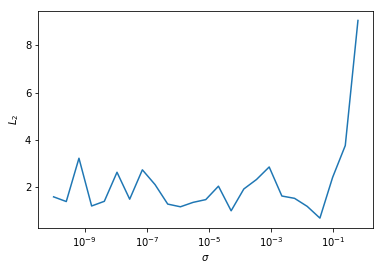

In [43]:
%matplotlib inline

plt.plot(stdevs[:25], parameter_l2_norm)
plt.xscale('log')
plt.xlabel('$\sigma$')
plt.ylabel('$L_{2}$')